Solution found: {'S1': (4536, 8568), 'S2': (2520, 8316), 'S3': (3528, 8316), 'S4': (5292, 7812), 'S5': (2772, 7308), 'S6': (4032, 7308), 'S7': (5040, 6804), 'S8': (1764, 6552)}


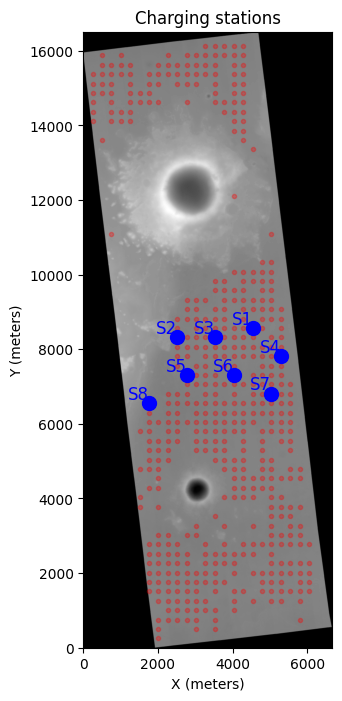

In [1]:
import numpy as np
from simpleai.search import CspProblem, backtrack
import matplotlib.pyplot as plt

###############Data and conversion################
tiles = np.load("tiles.npy")
map_data = np.load("map.npy") 
map_nr, map_nc = map_data.shape
nr, nc = tiles.shape
scale = 10.1175

valid_coordinates = [] #Valid coordinates in meters.
for i in range(nr):
    for j in range(nc):
        if tiles[i, j] == 1:
            x = j*252 #Each pixel represents a 252x252 m area.
            y = (nr-i)*252
            valid_coordinates.append((x,y))

def euclidean_distance(pos1, pos2):
    #Pythagorean theorem for distance between two coordinates.
    x = pos1[0]-pos2[0]
    y = pos1[1]-pos2[1]
    return np.sqrt(x**2+y**2) 
    
#############Constraint functions###############
def different(names, values):
    return len(values) == len(set(values)) #To make sure there is only one station on an available spot.

#Minimum distance constraint between two given stations (pairs).
def distance_min(variables, values):
    value1 = values[0]
    value2 = values[1]
    if euclidean_distance(value1, value2) >= 1000:
        return True
    else:
        return False

#Maximum distance from nearest neighbor
def distance_max(names, values):
    for i in range(len(values)):
        distances = [] #List of distances from one station to the rest.
        for j in range(len(values)):
            if i != j: #We only consider different stations.
                distances.append(euclidean_distance(values[i], values[j]))
        if min(distances)>3000: 
            return False
    return True

################Variables###############
variables = ["S1", "S2","S3", "S4", "S5", "S6", "S7", "S8"]
#Domains of variables
start_index = 150  #start index for different positions in the map.
valid_coordinates_station = valid_coordinates[start_index:] + valid_coordinates[:start_index]

domains = {}
for var in variables:
    domains[var] = valid_coordinates_station

#Constraints
constraints = []
for i in range(len(variables)):
    for j in range(i+1, len(variables)):
        constraints.append(([variables[i], variables[j]], distance_min))
#We append the other constraints
constraints.append((variables, different)) 
constraints.append((variables, distance_max))


################Solution##################
problem = CspProblem(variables, domains, constraints)
solution = backtrack(problem)

###############graph####################
if solution:
    print("Solution found:", solution)
    
    station_x = [solution[var][0] for var in variables]
    station_y = [solution[var][1] for var in variables]


    plt.figure(figsize=(10, 8))
    plt.imshow(map_data, cmap="grey", extent=[0, scale * map_data.shape[1], 0, scale * map_data.shape[0]])
    
    valid_x = [coord[0] for coord in valid_coordinates]
    valid_y = [coord[1] for coord in valid_coordinates]
    plt.scatter(valid_x, valid_y, color='red', marker='.', alpha=0.3, label="Valid Zones")

    plt.scatter(station_x, station_y, color='blue', marker='o', s=100, label="Charging Stations")

    for i, var in enumerate(variables):
        plt.text(station_x[i], station_y[i], var, color='blue', fontsize=12, ha='right', va='bottom')

    plt.xlabel("X (meters)")
    plt.ylabel("Y (meters)")
    plt.title("Charging stations")
    plt.savefig("charging_stations_plot.png", format="png")
    plt.show()

else:
    print("No solution found.")

### Optimization

In [2]:
answer = list(solution.values())

In [3]:
import time 
import random
import math

In [4]:

class Stations(object):
    def __init__(self, stations):
        self.stations = list(stations)

    def visibility(self):
        visualization = 0
        for point in valid_coordinates:
            seen = False #control for seen stations
            for station in self.stations:
                if euclidean_distance(station, point) <= 2000:
                    seen = True
            if seen:
                visualization += 1 #avoid redundancies
        return visualization
    
    def neighbor(self):
        n_station = Stations(self.stations) #copy our board

        valid_position = False
        while not valid_position: #select a random empty position
            random_index = random.randint(0, len(self.stations) - 1)
            n_station.stations[random_index] = random.choice(valid_coordinates)
            
            distances = []
            for index in range(len(n_station.stations)): #validation for the new station
                if index != random_index:
                    distances.append(euclidean_distance(n_station.stations[index], n_station.stations[random_index]))

            valid_position = min(distances) >= 1000 and min(distances) <= 3000 
        print(min(distances)**.5 * scale)
        return n_station

    def show(self):
        print(self.stations)

### Greedy search

In [5]:
print('Greedy search: ')

initial_state = Stations(answer)
vis = initial_state.visibility() #cost
step = 0
while step < 10000:

    neighbor = initial_state.neighbor()
    new_vis = neighbor.visibility()

    if new_vis > vis:
        initial_state = neighbor
        vis = new_vis

    print(f'Iteration No. {step} Visibility: {vis}')
    step +=1
    initial_state.show()

Greedy search: 
359.13562323306223
Iteration No. 0 Visibility: 298
[(4032, 6048), (2520, 8316), (2772, 15120), (5292, 7812), (2772, 7308), (3780, 7560), (5040, 6804), (1764, 6552)]
509.15947135557474
Iteration No. 1 Visibility: 315
[(4032, 6048), (1512, 4032), (2772, 15120), (5292, 7812), (2772, 7308), (3780, 7560), (5040, 6804), (1764, 6552)]
326.1262177793604
Iteration No. 2 Visibility: 315
[(4032, 6048), (1512, 4032), (2772, 15120), (5292, 7812), (2772, 7308), (3780, 7560), (5040, 6804), (1764, 6552)]
339.64950216679455
Iteration No. 3 Visibility: 321
[(4032, 6048), (1512, 4032), (2772, 15120), (5292, 7812), (5544, 5796), (3780, 7560), (5040, 6804), (1764, 6552)]
372.7116629102749
Iteration No. 4 Visibility: 328
[(4032, 6048), (1512, 4032), (2772, 15120), (5040, 8064), (5544, 5796), (3780, 7560), (1764, 6552), (1764, 6552)]
461.2121202290131
Iteration No. 5 Visibility: 337
[(4032, 6048), (1512, 4032), (2772, 15120), (3024, 8064), (756, 14616), (3780, 7560), (1764, 6552), (1764, 6552

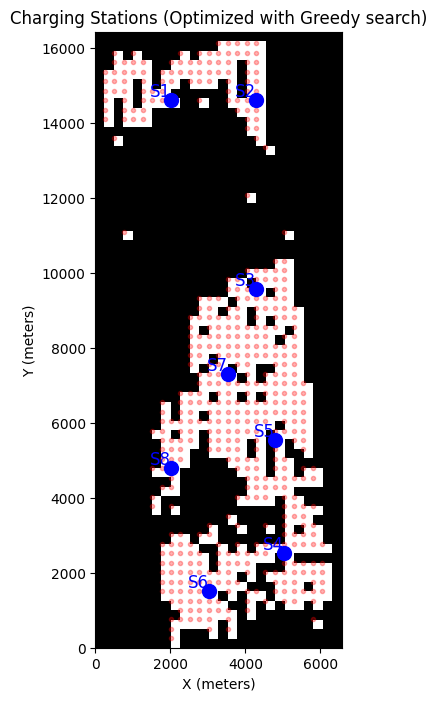

In [6]:
station_x = [station[0] for station in initial_state.stations]
station_y = [station[1] for station in initial_state.stations]
plt.figure(figsize=(10, 8))
plt.imshow(tiles, cmap="grey", extent=[0, scale* 25 * tiles.shape[1], 0, scale * 25* tiles.shape[0]])

valid_x = [coord[0] for coord in valid_coordinates]
valid_y = [coord[1] for coord in valid_coordinates]
plt.scatter(valid_x, valid_y, color='red', marker='.', alpha=0.3, label="Valid Zones")

plt.scatter(station_x, station_y, color='blue', marker='o', s=100, label="Charging Stations")

for i, var in enumerate(variables):
    plt.text(station_x[i], station_y[i], var, color='blue', fontsize=12, ha='right', va='bottom')

plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.title("Charging Stations (Optimized with Greedy search)")
plt.savefig("final_charging_stations.png", format="png")
plt.show()

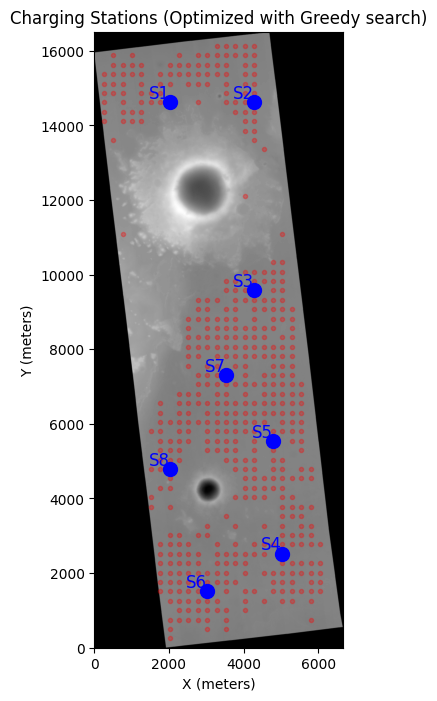

In [7]:
station_x = [station[0] for station in initial_state.stations]
station_y = [station[1] for station in initial_state.stations]

plt.figure(figsize=(10, 8))
plt.imshow(map_data, cmap="grey", extent=[0, scale * map_data.shape[1], 0, scale * map_data.shape[0]])

valid_x = [coord[0] for coord in valid_coordinates]
valid_y = [coord[1] for coord in valid_coordinates]
plt.scatter(valid_x, valid_y, color='red', marker='.', alpha=0.3, label="Valid Zones")

plt.scatter(station_x, station_y, color='blue', marker='o', s=100, label="Charging Stations")

for i, var in enumerate(variables):
    plt.text(station_x[i], station_y[i], var, color='blue', fontsize=12, ha='right', va='bottom')

plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.title("Charging Stations (Optimized with Greedy search)")
plt.savefig("final_charging_stations.png", format="png")
plt.show()

Simulated Annealing

In [8]:



t0 = 1000  
alpha = 0.99  
step = 1
st = Stations(random.sample(valid_coordinates, len(variables)))
visibility = st.visibility()
t = t0

while t > 0.05:
    
    t = t0 * math.pow(alpha, step)
    step += 1
    
    
    neighbor = st.neighbor()
    new_visibility = neighbor.visibility()

    
    if new_visibility > visibility:
        st = neighbor
        visibility = new_visibility
    else:
        
        p = math.exp(-(visibility - new_visibility)/t)
        if p >= random.random():
            st = neighbor
            visibility = new_visibility

print("Final visibility:", visibility)
st.show()


393.41336409684914
339.64950216679455
487.672442280653
487.672442280653
372.7116629102749
427.0866383996941
403.91360458388425
339.64950216679455
339.64950216679455
505.3357254136813
507.89446910751053
537.033016494683
326.1262177793604
515.3472344171071
359.13562323306223
403.91360458388425
321.2206666763519
533.7814057939956
359.13562323306223
467.849971721129
330.81988758194484
339.64950216679455
456.03882981744795
467.849971721129
542.3246211364242
406.41473711774313
431.29489667947877
406.41473711774313
487.672442280653
321.2206666763519
396.1173951359421
467.849971721129
480.33693241755077
321.2206666763519
433.35364203226106
339.64950216679455
433.35364203226106
480.33693241755077
339.64950216679455
427.0866383996941
518.9554867158847
359.13562323306223
326.1262177793604
339.64950216679455
372.7116629102749
326.1262177793604
326.1262177793604
339.64950216679455
507.89446910751053
403.91360458388425
381.99790229743513
415.983985849488
339.64950216679455
406.41473711774313
381.997

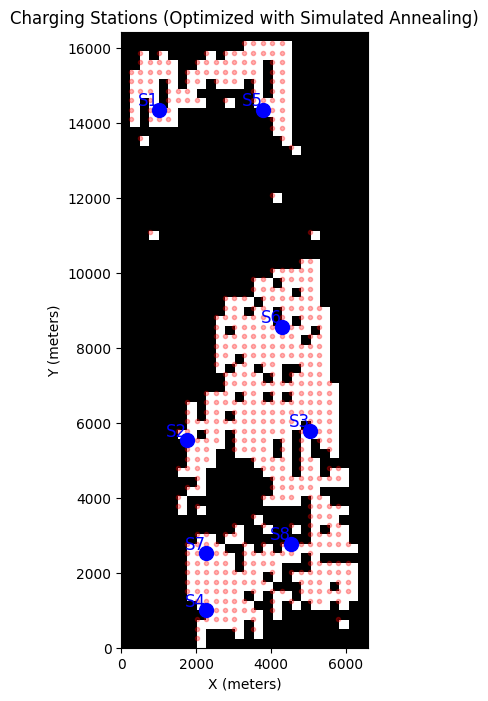

In [9]:
station_x = [station[0] for station in st.stations]
station_y = [station[1] for station in st.stations]
plt.figure(figsize=(10, 8))
plt.imshow(tiles, cmap="grey", extent=[0, scale * 25 * tiles.shape[1], 0, scale * 25 * tiles.shape[0]])

valid_x = [coord[0] for coord in valid_coordinates]
valid_y = [coord[1] for coord in valid_coordinates]
plt.scatter(valid_x, valid_y, color='red', marker='.', alpha=0.3, label="Valid Zones")

plt.scatter(station_x, station_y, color='blue', marker='o', s=100, label="Charging Stations")

for i, var in enumerate(variables):
    plt.text(station_x[i], station_y[i], var, color='blue', fontsize=12, ha='right', va='bottom')

plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.title("Charging Stations (Optimized with Simulated Annealing)")
plt.savefig("final_charging_stations_sa.png", format="png")
plt.show()


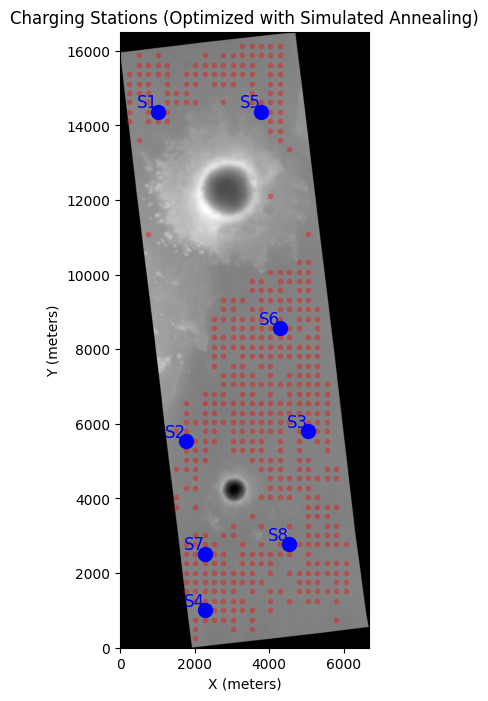

In [10]:
station_x = [station[0] for station in st.stations]
station_y = [station[1] for station in st.stations]

plt.figure(figsize=(10, 8))
plt.imshow(map_data, cmap="grey", extent=[0, scale * map_data.shape[1], 0, scale * map_data.shape[0]])

valid_x = [coord[0] for coord in valid_coordinates]
valid_y = [coord[1] for coord in valid_coordinates]
plt.scatter(valid_x, valid_y, color='red', marker='.', alpha=0.3, label="Valid Zones")

plt.scatter(station_x, station_y, color='blue', marker='o', s=100, label="Charging Stations")

for i, var in enumerate(variables):
    plt.text(station_x[i], station_y[i], var, color='blue', fontsize=12, ha='right', va='bottom')

plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.title("Charging Stations (Optimized with Simulated Annealing)")
plt.savefig("final_charging_stations_sa.png", format="png")
plt.show()